In [61]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.saving import register_keras_serializable
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score

In [62]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# plt.imshow(x_train[-1])

In [63]:
@register_keras_serializable(package="Custom")
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_clusters, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = 16
        self.num_experts = num_clusters # suggestion that #clusters == #experts

        self.experts = [self.build_expert() for _ in range(self.num_experts)]
        self.gate = self.build_gate()

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts] # (batch_size, H, W, C)
        # print("Expert outputs shape:", expert_outputs[0].shape)
        gate_output = self.gate(inputs) # (batch_size, num_experts)
        # print("Gate output shape:", gate_output.shape)
        weighted_expert_outputs = [
            tf.multiply(
                expert_output,
                tf.expand_dims(tf.expand_dims(tf.expand_dims(gate_output[:, i], axis=1), axis=1), axis=1)# (batch_size, 1, 1, 1)
            )
            for i, expert_output in enumerate(expert_outputs)
        ]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        return aggregated_output

    def build_expert(self):
        """ Conv Autoencoder. """
        # Encoder
        inputs = Input(shape=self.input_dim)
        x = Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        latent_space = Dense(self.latent_dim, activation="relu")(x)

        # Decoder
        x = Dense(4 * 4 * 8, activation="relu")(latent_space)
        x = Reshape((4, 4, 8))(x)
        x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation="relu", padding="valid")(x)
        x = UpSampling2D((2, 2))(x)
        outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

        # Autoencoder
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def build_gate(self):
        inputs = Input(shape=self.input_dim)
        x = inputs
        x = Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        x = Dense(self.num_experts, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        return model

    def get_expert_outputs(self, x):
        return [expert(x) for expert in self.experts]

    def get_cluster_assignments(self, x):
        gating_weights = self.gate(x)
        return tf.argmax(gating_weights, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "num_clusters": self.num_experts,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


input_dim = (28,28,1)
num_clusters = 2

model = MixtureOfExperts(input_dim, num_clusters)
model.compile(optimizer='adam', loss='mse')
# model.experts[0].summary()
model.summary()

Model: "mixture_of_experts_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_18 (Functional)           │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_19 (Functional)           │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_20 (Functional)           │ (None, 2)                   │           1,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,076 (62.80 KB)

 Trainable params: 16,076 (62.80 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.get_config()

{'name': 'mixture_of_experts_6',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'input_dim': (28, 28, 1),
 'num_clusters': 2}

In [65]:
history = model.fit(
    x_train, x_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, x_test)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0934 - val_loss: 0.0366
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0354 - val_loss: 0.0313
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0306 - val_loss: 0.0283
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0282 - val_loss: 0.0265
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0264 - val_loss: 0.0253
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0252 - val_loss: 0.0244
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0243 - val_loss: 0.0234
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0235 - val_loss: 0.0226
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0228 - val_loss: 0.0227
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0224 - val_loss: 0.0219
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0219 - val_loss: 0.0213
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0194
Test MSE Loss: 0.019218219444155693


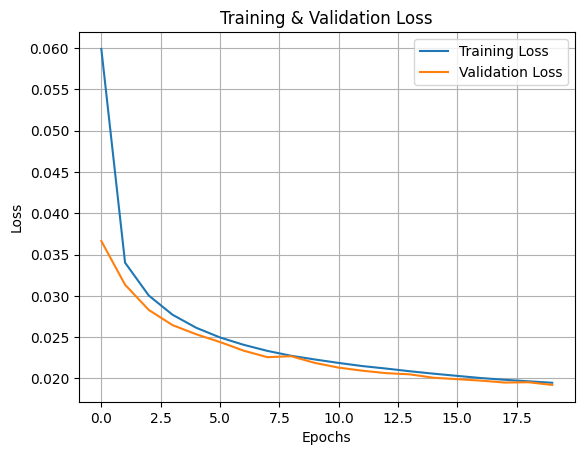

In [66]:
print("Test MSE Loss:", model.evaluate(x_test, x_test))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

NMI: 0.0836


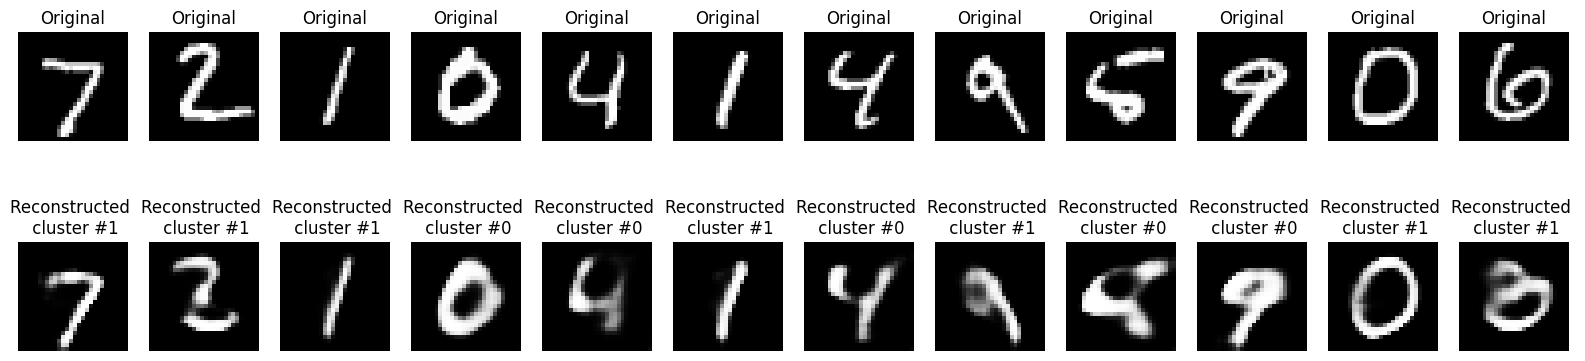

In [67]:
gating_weights = model.gate(x_test)
cluster_assignments = tf.argmax(gating_weights, axis=1)
nmi = normalized_mutual_info_score(y_test, cluster_assignments)
print(f'NMI: {nmi:.4f}' )


plt.figure(figsize=(20, 5))
n_to_show = 12
expert_outputs = model.get_expert_outputs(x_test[:n_to_show])
for i in range(n_to_show):
    plt.subplot(2, n_to_show, i + 1)
    plt.imshow(x_test[i].squeeze(),  cmap="gray")
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, n_to_show, i + n_to_show + 1)
    plt.imshow(expert_outputs[cluster_assignments[i]][i].numpy().reshape(28, 28),  cmap="gray")
    plt.title(f"Reconstructed \n cluster #{cluster_assignments[i]}")
    plt.axis('off')

plt.show()

In [68]:
top_expert = cluster_assignments
unique_labels = np.unique(y_test)
results = []

for label in unique_labels:
    mask = (y_test == label)
    top_experts_for_label = top_expert[mask]
    counts = np.bincount(top_experts_for_label, minlength=model.num_experts)
    
    dominant_expert = np.argmax(counts)
    percentage = (counts[dominant_expert] / len(top_experts_for_label)) * 100
    
    results.append({
        'Label': label,
        'Dominant Expert': dominant_expert,
        'Percentage': percentage
    })

from pandas import DataFrame
DataFrame(results)

,Label,Dominant Expert,Percentage
0,0,1,77.551020
1,1,0,53.832599
2,2,0,52.810078
3,3,1,97.821782
4,4,0,66.802444
5,5,1,96.748879
6,6,0,54.279749
7,7,1,61.186770
8,8,1,86.036961
9,9,1,77.006938


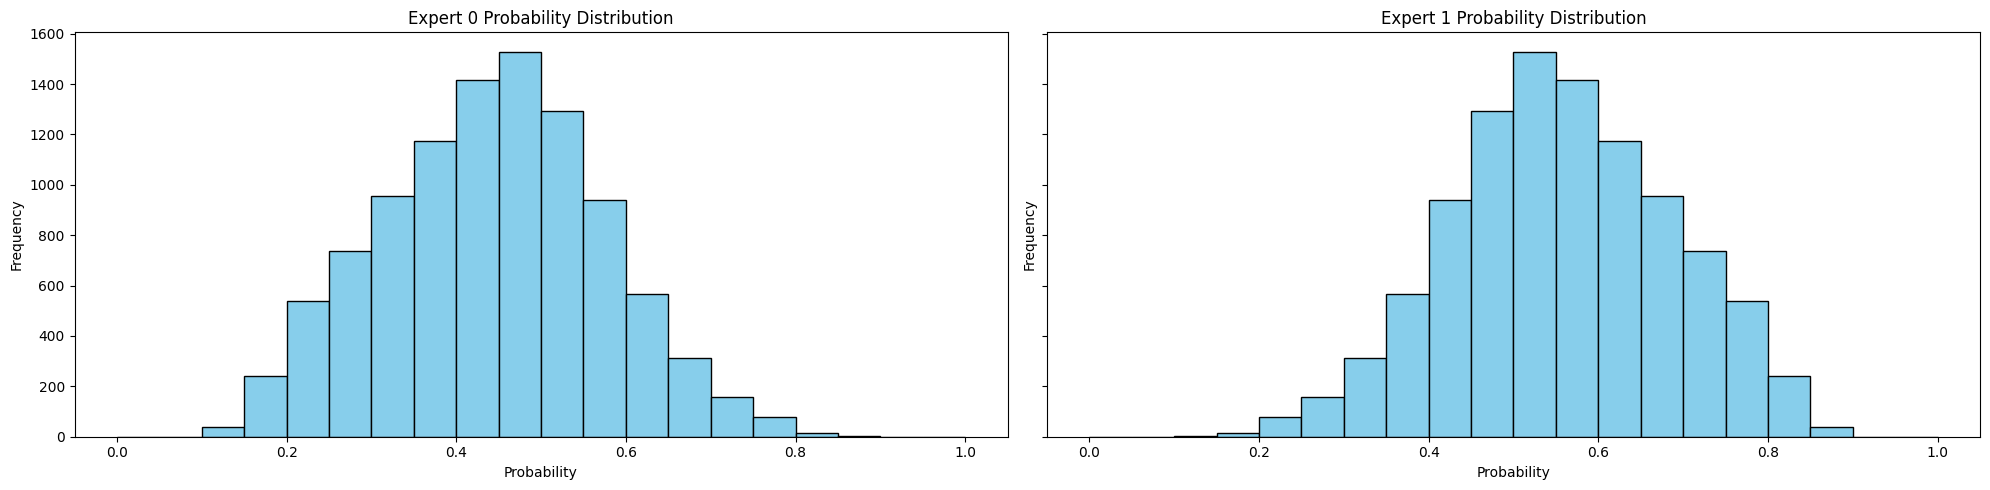

In [69]:
fig, axes = plt.subplots(1, model.num_experts, figsize=(20, 5), sharey=True)
for i in range(model.num_experts):
    axes[i].hist(gating_weights[:, i], bins=20, range=(0, 1), color='skyblue', edgecolor='black')
    axes[i].set_title(f'Expert {i} Probability Distribution')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [71]:
filepath = "MoA_Conv_Auto_Conv_Gate_THE_BEST.keras"
model.save(filepath)